# Initialization

## Installing Libraries

In [1]:
!pip install pyLDAvis
!pip install wordcloud
!pip install fasttext
!pip install mlxtend
!pip install google-cloud-storage
!pip install google-cloud-bigquery
!pip install google-cloud-bigquery-storage
!pip install db-dtypes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 405.0/405.0 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.1/511.1 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 911.7 kB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.1-py3-none-any.whl (238 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp310-cp310-linux_x86_64.whl size=4246764 sha256=a16788c49f0d30d9f53e0e97dd960b0ae8b2db9a48890814dea3b38d8e397b7f
  Stored in directory: /root/.cache/pip/wheels/0d/a2/00/81db54d3e6a8199b829d58e02cec2ddb20ce3e59fad8d3c92a
Successfully built fasttext
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.0/239.0 kB 2.0 MB/s eta 0:00:00
INFO: pip is lookin

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 5.2 MB/s eta 0:00:00


## Importing Libraries

In [3]:
import numpy as np
import pandas as pd
import scipy as sp
import json
import shutil
import os
import time
import multiprocessing
import subprocess
import re
import string
import spacy
import gensim
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import fasttext

from google.colab import auth
from google.colab import drive
from google.cloud import bigquery

from collections import Counter
from wordcloud import WordCloud,STOPWORDS

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import LancasterStemmer, WordNetLemmatizer
nltk.download('stopwords')
stop_words = stopwords.words('english')
nlp = spacy.load('en_core_web_sm')

from gensim.models import Word2Vec
from gensim import corpora, models
from gensim.similarities import MatrixSimilarity
from gensim.matutils import corpus2csc, sparse2full, corpus2dense
from gensim.models.coherencemodel import CoherenceModel

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.exceptions import ConvergenceWarning
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.utils import resample

from mlxtend.plotting import plot_confusion_matrix


import pyLDAvis.gensim
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

%matplotlib inline
pd.set_option('display.max_colwidth', None)

warnings.simplefilter(action = 'ignore', category = FutureWarning)
warnings.filterwarnings(action = "ignore", category = DeprecationWarning)
warnings.filterwarnings(action = "ignore", category = ConvergenceWarning)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Defining Classes, Functions, Dictonaries

### Memory_recorder Class

In [4]:
##### Memory recorder ######

class Memory_recorder:
  def __init__(self):
    self.running = True  # Flag to control recording
    self.recording_thread = None  # Thread for background recording
    self.lowest_memory = None  # Store the lowest memory value
    self.filename = "memory_info.txt"  # File to store memory recordings
    self.total_memory = None

  def compile_recorder(self):
    with open("memory_recorder.cpp", "w") as f:
      f.write("""
      #include <iostream>
      #include <fstream>
      #include <sstream>
      #include <string>
      #include <regex>

      using namespace std;

      bool running = true;
      const int MAX_BUFFER_SIZE = 1024;
      char buffer[MAX_BUFFER_SIZE];

      string command = ("grep MemAvailable: /proc/meminfo");


      void read_memory_info(int lowest_memory) {
        ofstream outfile("memory_info.txt", ios::trunc);
        while (running) {
          FILE* process = popen(command.c_str(), "r");
          if (fgets(buffer, MAX_BUFFER_SIZE, process) != nullptr) {
            string line(buffer);
            std::regex regex(R"(\d+)");
            std::smatch match;
            while (std::regex_search(line, match, regex)) {
              int mem = std::stoi(match.str());
              if (mem < lowest_memory) {
                lowest_memory = mem;
                outfile.open("memory_info.txt");
                outfile << lowest_memory;
                outfile.close();
              }
              break;
            }
          }
          pclose(process);
        }
      }


      int main() {
        int lowest_memory = 999999999;
        running = true;
        read_memory_info(lowest_memory);
      }
      """)

    with open("total_memory.cpp", "w") as f:
      f.write("""
      #include <iostream>
      #include <fstream>
      #include <sstream>
      #include <string>
      #include <regex>

      using namespace std;


      const int MAX_BUFFER_SIZE = 1024;
      char buffer[MAX_BUFFER_SIZE];

      string command = ("grep MemTotal: /proc/meminfo");

      void total_memory() {
        FILE* process = popen(command.c_str(), "r");
        if (fgets(buffer, MAX_BUFFER_SIZE, process) != nullptr) {
          string line(buffer);
          std::regex regex(R"(\d+)");
          std::smatch match;
          while (std::regex_search(line, match, regex)) {
            int mem = std::stoi(match.str());
            cout << mem;
            break;
          }
        }
        pclose(process);
      }

      int main() {
        total_memory();
      }
      """)

    subprocess.run(["g++", "total_memory.cpp", "-o", "total_memory.exe"])
    subprocess.run(["g++", "memory_recorder.cpp", "-o", "memory_recorder.exe"])

    self.total_memory = subprocess.run('./total_memory.exe', shell = True, check = True, capture_output = True).stdout.decode('utf-8')
    self.total_memory = int(self.total_memory)
    os.remove('total_memory.cpp')
    os.remove('total_memory.exe')
    os.remove('memory_recorder.cpp')

  def record_in_background(self):
    while self.running:
      self.lowest_memory = subprocess.run('./memory_recorder.exe', shell = True, check = True, capture_output = True)

  def start_recording(self):
    # Create a thread to perform recording in the background
    self.lowest_memory = None  # Reset lowest_memory for each iteration
    self.running = True
    self.recording_thread = multiprocessing.Process(target = self.record_in_background)
    self.recording_thread.start()
    # print("Memory information recording started in the background.")

  def stop_recording(self):
    self.running = False
    self.recording_thread.terminate()
    subprocess.run('pkill -f memory_recorder.exe', shell = True)
    os.remove(self.filename)
    print("Memory information recording stopped.")

  def get_recording(self):
    # print("Memory information recording stopped.")
    self.recording_thread.terminate()
    while not os.path.isfile("memory_info.txt"):
      time.sleep(2)
    while os.path.isfile("memory_info.txt"):
      try:
        with open(self.filename, "r") as f:
          try:
            lines = f.readlines()[0]
          except:
            time.sleep(1)
            break
          self.lowest_memory = int(lines)
          if self.lowest_memory is None:
            break
          f.close()
          self.running = False
          subprocess.run('pkill -f memory_recorder.exe', shell = True)
          os.remove(self.filename)
          break
      except:
        continue

    peak = np.round((self.total_memory - self.lowest_memory)/(1024*1024), 2) # returns GBs
    return peak

  def kill(self):
    self.running = False
    try:
      self.recording_thread.terminate()
      print('Thread terminated.')
    except:
      print('No thread to terminate.')
    try:
      subprocess.run('pkill -f memory_recorder.exe', shell = True)
      print('Subprocess terminated.')
    except:
      print('No subprocess to terminate.')
    try:
      os.remove(self.filename)
      print(f'Removed: "{self.filename}"')
    except:
      print(f'Could not remove "{self.filename}"')
    try:
      os.remove('memory_recorder.exe')
      print('Removed: "memory_recorder.exe"')
    except:
      print('Could not remove "memory_recorder.exe".')


In [5]:
##### FAST TEXT VECTORIZER - sklearn gridsearchcv compatible ######)

class FastTextVectorizer(TransformerMixin, BaseEstimator):

  def __init__(self, *, params = 1):
    self.params = params
    self.model = None

  def fit(self, X, y=None):
    with open('haha.txt', 'w') as f:
      f.write('\n'.join(X))
    self.model = fasttext.train_unsupervised('haha.txt')
    os.remove('haha.txt')
    return self

  def fasttext_vectorize(self, text):
    return self.model.get_sentence_vector(text)

  def transform(self, X):
    X_vect = X.apply(self.fasttext_vectorize)
    return X_vect

### Functions

In [189]:
def timer_start():
  return time.time()

def timer_stop(start_time):
  return time.time() - start_time

# ## Bytes conversion
# ## from https://psutil.readthedocs.io/en/latest/#running-tests

# def bytes2human(n):
#     # http://code.activestate.com/recipes/578019
#     # >>> bytes2human(10000)
#     # '9.8K'
#     # >>> bytes2human(100001221)
#     # '95.4M'
#     symbols = ('K', 'M', 'G', 'T', 'P', 'E', 'Z', 'Y')
#     prefix = {}
#     for i, s in enumerate(symbols):
#         prefix[s] = 1 << (i + 1) * 10
#     for s in reversed(symbols):
#         if abs(n) >= prefix[s]:
#             value = float(n) / prefix[s]
#             return '%.1f%s' % (value, s)
#     return "%sB" % n

# 1 #
### LOWERCASE ###
def lowercase(text):
    return text.lower()


# 2 #
### HTML TAGS ###
html_tags = '<.*?>'
compiled_tags = re.compile(html_tags)

def remove_tags(text):
  return compiled_tags.sub(' ', text)


# 2.5 #
### URL TAGS ###

url_pattern = re.compile(r'https?://\S+')

def remove_url(text):
    return url_pattern.sub(' ', text)

### New Lines ###

newline_pattern = re.compile(r'\n')

def remove_newline(text):
    return newline_pattern.sub(' ', text)

# 3 #
### PUNCTUATION ###
puncs = string.punctuation
re_puncs = '[' + '\\'.join([punc for punc in puncs]) + ']'
compiled_puncs = re.compile(re_puncs)

def remove_puncs(text):
  return compiled_puncs.sub(' ', text)


# 4 #
### STOP-WORDS ###
nltk.download('stopwords')
stop_words = stopwords.words('english')

def remove_sw(text):
  return ' '.join([word for word in text.split(' ') if word not in stop_words])


# 5 #
### LEMMA ###
nlp = spacy.load('en_core_web_sm')

def lemmatize(text, allowed_postags = ['NOUN', 'VERB', 'ADJ']):
  return [word.lemma_ for word in nlp(text) if word.pos_ in allowed_postags]


### x_encoder_y ###
def x_encoder_y(the_x, the_y, features):

  if features != 'Text Only':
    the_x = the_x.fillna(0)

  x = the_x
  y = the_y
  le = LabelEncoder()
  le.fit(y)
  y = le.transform(y)

  return x, y

### for FastText only ###
def transform_param_dict(param_dict):
  new_dict = {}
  for key, value in param_dict.items():
    new_dict[key.split('__')[1]] = value
  return new_dict

### Fixing Some Features ###
def turn_boolean(x):
  if x == True:
    return 1
  else:
    return 0


### Fixing text columns ###
def replace_non_text(text):
  if type(text) != str:
    text = None
    return text
  else:
    return text

def remove_newline(text):
  return text.replace('\n', ' ')

def drop_rows_not_text(df):
  for text in ['text', 'light_clean_text', 'clean_text']:
    try:
      df[text] = df[text].apply(replace_non_text)
      df = df[df[text] != None]
      df[text].dropna(inplace = True)
      df[text] = df[text].apply(remove_newline)
    except:
      continue
  return df

# 6 #
### RECORD TUNE RESULTS ###
def record_tune_results(name, preproc, features, ID, tune_results_dict, classifier, duration, grid_search_tune, training_size, system):
  if system == 'TPU':
    cost_per_min = 0.0033645
  else:
    cost_per_min = 0.0001338

  if preproc == 'text':
    preproc_name = 'Raw Text'
  else:
    preproc_name = 'Clean Text'

  try:
    vectorizer_name = str(grid_search_tune.best_estimator_.steps[0][1]).split('(')[0]
    if vectorizer_name == 'GridSearchCV':
      vectorizer_name = 'FastText'
    best_parameters = str(grid_search_tune.best_estimator_.steps[0][1]).split(vectorizer_name)[1]
    best_score = np.round(grid_search_tune.best_score_, 4)
  except:
    vectorizer_name = grid_search_tune.__class__.__name__
    if vectorizer_name == 'GridSearchCV':
      vectorizer_name = 'FastText'
    try: # monkey business - no time to fix
      best_parameters = str(grid_search_tune.best_estimator_.steps[0][1]).split(vectorizer_name)[1]
    except:
      best_parameters = "Default"
    try:
      best_score = np.round(grid_search_tune.best_score_, 4)
    except:
      best_score = "Default"

  tune_results_dict[ID] = {'Dataset': name,
                          'Preprocessing': preproc_name,
                          'Features': features,
                          'Training Size': training_size,
                          'Vectorizer': vectorizer_name,
                          'Classifier': classifier.split('_')[0],
                          'Best Parameters': best_parameters,
                          'Best Score': best_score,
                          'Duration (m)': np.round(duration, 2),
                          #'Peak Memory (GB)': record,
                          'System' : system,
                          'Cost (€)': np.round(duration * cost_per_min, 4)}

  return


# 7 #
### RECORD CLASSIFIER RESULTS ###
def record_classifier_results(name, preproc, features, ID, clf_results_dict, vectorizer, classifier, duration, grid_search_tune, training_size, results, system, default = False):
  if system == 'TPU':
    cost_per_min = 0.0033645
  else:
    cost_per_min = 0.00024743 # CPU COST per min

  if preproc == 'text':
    preproc1 = 'Raw Text'
  elif preproc == 'clean_text':
    preproc1 = 'Clean Text'
  else:
    preproc1 = preproc

  try:
    best_score = grid_search_tune.best_score_
  except:
    default = True

  if default:
    vectorizer_name = vectorizer.__class__.__name__
    classifier_name = f'{classifier=}'.split('=')[0]
    clf_results_dict[ID] = {'Dataset': name,
                            'Preprocessing': preproc1,
                            'Features': features,
                            'Training Size': training_size,
                            'Vectorizer': vectorizer_name,
                            'Classifier': classifier_name,
                            'Best Parameters': "Default",
                            'Best Score': "Default",
                            'Duration (s)': np.round(duration * 60, 1),
                            #'Peak Memory (GB)': record,
                            'Accuracy Score': results[0],
                            'F1 Score': results[1],
                            'Precision Score': results[2],
                            'Recall Score': results[3],
                            'System' : system,
                            'Cost (€)': np.round(duration * cost_per_min, 4)}

  else:
    vectorizer_name = vectorizer.__class__.__name__
    classifier_name = f'{classifier=}'.split('=')[0]
    best_parameters = str(vectorizer).split(vectorizer_name)[1]
    clf_results_dict[ID] = {'Dataset': name,
                            'Preprocessing': preproc1,
                            'Features': features,
                            'Training Size': training_size,
                            'Vectorizer': vectorizer_name,
                            'Classifier': classifier_name,
                            'Best Parameters': best_parameters,
                            'Best Score': np.round(best_score, 4),
                            'Duration (s)': np.round(duration * 60, 1),
                            #'Peak Memory (GB)': record,
                            'Accuracy Score': results[0],
                            'F1 Score': results[1],
                            'Precision Score': results[2],
                            'Recall Score': results[3],
                            'System' : system,
                            'Cost (€)': np.round(duration * cost_per_min, 4)}

  return


# 8 #
### TUNER ###
def model_tune(name, preproc, features, model_name, tuning_dict, X_train, y_train, tune_results_dict, training_size, ID, system, cv_number = 2, jobs = -1):
  # recorder.start_recording()
  start = timer_start()

  if tuning_dict[model_name]['pipeline'][0][0] == 'ftvect':
    vectorizer = FastTextVectorizer() # for 'ftvect'

    pipeline = tuning_dict[model_name]['pipeline'][1][1]
    parameters = transform_param_dict(tuning_dict[model_name]['parameter_ranges'])
    grid_search_tune = GridSearchCV(pipeline, parameters, cv = 2, n_jobs = -1, error_score = 0.0)
    if features != 'Text Only':

      X_train_features = X_train.drop(columns = preproc)
      X_train_temp = X_train[preproc]
      vectorizer.fit(X_train_temp)
      X_train_vec = vectorizer.transform(X_train_temp)
      combined_data = np.concatenate((X_train_features, pd.DataFrame(X_train_vec.to_frame(name = 'vectors').vectors.tolist(), index = X_train_vec.to_frame(name = 'vectors').index)), axis=1)

      grid_search_tune.fit(combined_data, y_train)
    else:
      vectorizer.fit(X_train)
      X_train = vectorizer.transform(X_train)
      X_train = pd.DataFrame(X_train.to_frame(name = 'vectors').vectors.tolist())
      grid_search_tune.fit(X_train, y_train)

  else:
    pipeline = Pipeline(tuning_dict[model_name]['pipeline'])
    parameters = tuning_dict[model_name]['parameter_ranges']
    grid_search_tune = GridSearchCV(pipeline, parameters, cv = 2, n_jobs = -1, error_score = 0.0)
    if features != 'Text Only':
      X_train_temp = X_train[preproc]
      grid_search_tune.fit(X_train_temp, y_train)
    else:
      grid_search_tune.fit(X_train, y_train)



  duration = timer_stop(start)/60
  # record = recorder.get_recording()

  record_tune_results(name, preproc, features, ID, tune_results_dict, model_name, duration, grid_search_tune, training_size, system)

  return grid_search_tune


# 9 #
### CLASSIFIERS ###
def classifier_run(name, preproc, features, grid_search_tune, pipe, model_dict, X_train, X_test, y_train, y_test, clf_results_dict, training_size, ID, system, default = False):
  #recorder.start_recording()
  start = timer_start()
  classifier = model_dict[pipe.split('_')[0]]
  model = classifier


  if features != 'Text Only':
    X_train_features = X_train.drop(columns = preproc)
    X_train_temp = X_train[preproc]
    X_test_features = X_test.drop(columns = preproc)
    X_test_temp = X_test[preproc]

  if pipe.split('_')[1] == 'ftvect':
    vectorizer = FastTextVectorizer()
    # vectorizer.fit(X_train)
    if features != 'Text Only':

      vectorizer.fit(X_train_temp)
      X_train_vec = vectorizer.transform(X_train_temp)
      X_test_vec = vectorizer.transform(X_test_temp)
      X_train_combined = np.concatenate((X_train_features, pd.DataFrame(X_train_vec.to_frame(name = 'vectors').vectors.tolist(), index = X_train_vec.to_frame(name = 'vectors').index)), axis=1)
      X_test_combined = np.concatenate((X_test_features, pd.DataFrame(X_test_vec.to_frame(name = 'vectors').vectors.tolist(), index = X_test_vec.to_frame(name = 'vectors').index)), axis=1)

      model.fit(X_train_combined, y_train)
      pred = model.predict(X_test_combined)

    else:
      vectorizer.fit(X_train)
      X_train_vec = vectorizer.transform(X_train)
      X_test_vec = vectorizer.transform(X_test)
      if pipe.split('_')[1] == 'ftvect':
        X_train_vec = pd.DataFrame(X_train_vec.to_frame(name = 'vectors').vectors.tolist())
        X_test_vec = pd.DataFrame(X_test_vec.to_frame(name = 'vectors').vectors.tolist())

      model.fit(X_train_vec, y_train)
      pred = model.predict(X_test_vec)


  else:
    vectorizer = grid_search_tune.best_estimator_.steps[0][1]
    if features != 'Text Only':
      vectorizer.fit(X_train_temp)
      X_train_vec = sp.sparse.hstack((vectorizer.transform(X_train_temp), X_train_features.values.astype('float64')), format = 'csr')
      X_test_vec = sp.sparse.hstack((vectorizer.transform(X_test_temp), X_test_features.values.astype('float64')), format = 'csr')
    else:
      vectorizer.fit(X_train)
      X_train_vec = vectorizer.transform(X_train)
      X_test_vec = vectorizer.transform(X_test)

    model.fit(X_train_vec, y_train)
    pred = model.predict(X_test_vec)


  duration = timer_stop(start)/60
  #record = recorder.get_recording()

  results = []
  results.append(np.round(accuracy_score(y_test, pred), 4))
  results.append(np.round(f1_score(y_test, pred, average = 'weighted'), 4))
  results.append(np.round(recall_score(y_test, pred, average = 'weighted'), 4))
  results.append(np.round(precision_score(y_test, pred, average = 'weighted', zero_division = 0), 4)) ### note ###

### precision_score###
# zero_division{“warn”, 0.0, 1.0, np.nan}, default=”warn”
# Sets the value to return when there is a zero division.
# Notes: - If set to “warn”, this acts like 0, but a warning is also raised. - If set to np.nan, such values will be excluded from the average.

  record_classifier_results(name, preproc, features, ID, clf_results_dict, vectorizer, classifier, duration, grid_search_tune, training_size, results, system, default)

  return

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Dictionaries

In [7]:
# https://datascience.stackexchange.com/questions/72791/training-a-classifier-with-text-and-numerical-features-what-is-the-state-of-th

#word2vec, FastText, Elmo, Flair or transformer-based embeddings like BERT
#Neural Networks, I concatenate two different branches (one for text and another for the numerical values) at the very last steps of the network.

In [8]:
# https://stackoverflow.com/questions/56392852/nlp-how-to-add-more-features
#
# x_tfidf = hstack((x_tfidf , np.array(df['additonal_feature'])[:,None]))
# x_tfidf = x_tfidf.tocsr()
#
# The above code is simply adding your additional column to your tf-idf matrix.
# If your TF-IDF matrix is of dimension M x N, with this step it will add another column
# of dimension 1 x N, and it will result an array of M+1 x N. So in the end, your model
# is going to treat the additional column just as an additional nlp token.

#
#
# https://stackoverflow.com/questions/53841913/perform-feature-selection-using-pipeline-and-gridsearch

In [9]:
# TFIDF PARAMETERS
#
# STARTED WITH THESE
#
# parameter_ranges = {
#             'tfidf__max_df': (0.25, 0.5, 0.75, 1.0),
#             'tfidf__max_features': (None, 5000, 10000, 50000),
#             'tfidf__ngram_range': ((1, 1), (1, 2), (1,3)),
#             'tfidf__use_idf': (True, False),
#             'tfidf__norm': ('l1', 'l2', None)
#             }
#
# After testing ended up with these:
#
# parameter_ranges = {
#             'tfidf__max_df': (0.25, 0.5),
#             'tfidf__max_features': (None, 5000, 10000, 50000),
#             'tfidf__ngram_range': ((1, 1), (1, 2), (1,3)),
#             'tfidf__use_idf': (True, False),
#             'tfidf__norm': ('l1', 'l2', None)
#             }

# WORD2VEC PARAMETERS
#
# chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://arxiv.org/pdf/1804.04212
#
# 'window':[3, 5, 7]
# 'iter': [5, 90, 110, 130, 150]
# 'sample':[1e-5, 1e-4, 1e-3]

# FastText Parameters
#
# chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://aclanthology.org/2023.unlp-1.3.pdf
#
# 'ftvect__model': ('cbow', 'skipgram'),
# 'ftvect__epoch': (5, 10 ,15),
# 'ftvect__minn': (2, 3, 4, 5),
# 'ftvect__maxn': (5,6),
# 'ftvect__neg': (5, 10, 15)

In [10]:
# https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/

In [86]:
### Vectorizers ###

# TFIDF
parameter_ranges_tfidf = {
    'tfidf__max_df': (0.25, 0.5),
    'tfidf__max_features': (None, 5000, 10000),
    'tfidf__ngram_range': [(1, 2), (1,3)],
    # 'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2', None)
    }

# Word2Vec
# parameter_ranges_word2vec = {}
#     'word2vec__window':(3, 5, 7),
#     'word2vec__epochs': (5, 90, 110, 130, 150),
#     'word2vec__sample':(1e-5, 1e-4, 1e-3)
#     }

# CountVectorizer
parameter_ranges_count = {
    'count__ngram_range': [(1, 2),(2,2)],
    'count__max_df': (0.5, 0.75, 1),
    'count__min_df': (0.1, 1, 5),
    'count__max_features': (None, 100, 1000)
    }

# FastText
parameter_ranges_ftvect = {}
#     'ftvect__model': ('cbow', 'skipgram'),
#     'ftvect__epoch': (5, 10 ,15),
#     'ftvect__minn': (2, 3, 4, 5),
#     'ftvect__maxn': (5,6),
#     'ftvect__neg': (5, 10, 15)
#     }

### Classifiers ###

# Logistic Regression
parameter_ranges_LogisticRegression = {
    'classifier__C' : (100, 10, 1.0, 0.1),
    'classifier__solver' : ('newton-cg', 'lbfgs', 'liblinear')
    }

# Support Vector Machine
parameter_ranges_SVC = {
    'classifier__C' : [50, 10, 1.0],
    'classifier__kernel' : ['poly', 'rbf', 'sigmoid']
    }

# Bagged Decision Trees
parameter_ranges_BaggingClassifier = {
    'classifier__n_estimators' : [10, 100],
    'classifier__max_features' : [1.0, 0.3, 0.1]
    }

# Random Forest
parameter_ranges_RandomForestClassifier = {
    'classifier__n_estimators' : [10, 100],
    'classifier__max_features' : ['sqrt', 'log2']
    }

# Stochastic Gradient Boosting
parameter_ranges_GradientBoostingClassifier = {
    'classifier__n_estimators' : [10, 100],
    'classifier__max_depth' : [3, 5],
    'classifier__learning_rate' : [0.01, 0.1]
    }
# parameter_ranges_GradientBoostingClassifier = {
#     'classifier__n_estimators' : [10, 100, 1000],
#     'classifier__max_depth' : [3, 7, 9],
#     'classifier__learning_rate' : [0.001, 0.01, 0.1],
#     'classifier__subsample' : [0.5, 0.7, 1.0]
#     }

## Models ##

model_dict = {
    'LogisticRegression': LogisticRegression(),
    'SVC': SVC(),
    'BaggingClassifier': BaggingClassifier(),
    'RandomForestClassifier': RandomForestClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier()
    }

vectorizer_dict = {
    'tfidf': TfidfVectorizer(),
    'count': CountVectorizer(),
    #'word2vec': Word2Vec(),
    'ftvect': FastTextVectorizer()
    }

## Making the tuning dictionary ##

tuning_dict = {}
for model in model_dict.keys():
  for vectorizer in vectorizer_dict.keys():
    # Grabbing parameters
    temp_params = globals()[f'parameter_ranges_{vectorizer}'].copy()
    temp_params.update(globals()[f'parameter_ranges_{model}'])
    # Creating the pipe
    temp_pipe = {
        model + '_' + vectorizer: {
        'pipeline': [
        (vectorizer, vectorizer_dict[vectorizer]),
        ('classifier', model_dict[model])
        ],
        'parameter_ranges': temp_params
                 }
        }
    # Adding the pipe to the tuning dictionary
    tuning_dict.update(temp_pipe)

In [87]:
tuning_dict

{'LogisticRegression_tfidf': {'pipeline': [('tfidf', TfidfVectorizer()),
   ('classifier', LogisticRegression())],
  'parameter_ranges': {'tfidf__max_df': (0.25, 0.5),
   'tfidf__max_features': (None, 5000, 10000),
   'tfidf__ngram_range': [(1, 2), (1, 3)],
   'tfidf__norm': ('l1', 'l2', None),
   'classifier__C': (100, 10, 1.0, 0.1),
   'classifier__solver': ('newton-cg', 'lbfgs', 'liblinear')}},
 'LogisticRegression_count': {'pipeline': [('count', CountVectorizer()),
   ('classifier', LogisticRegression())],
  'parameter_ranges': {'count__ngram_range': [(1, 2), (2, 2)],
   'count__max_df': (0.5, 0.75, 1),
   'count__min_df': (0.1, 1, 5),
   'count__max_features': (None, 100, 1000),
   'classifier__C': (100, 10, 1.0, 0.1),
   'classifier__solver': ('newton-cg', 'lbfgs', 'liblinear')}},
 'LogisticRegression_ftvect': {'pipeline': [('ftvect', FastTextVectorizer()),
   ('classifier', LogisticRegression())],
  'parameter_ranges': {'classifier__C': (100, 10, 1.0, 0.1),
   'classifier__solve

In [88]:
spliting_sizes = {
    'tiny': [15000, [500, 800, 1000, 2000]],#, 10000]],
    'small': [50000, [10000, 15000, 25000, 35000]],
    'medium': [200000, [50000, 100000, 125000, 150000]],
    'large': [400000, [100000, 150000, 200000, 300000]],
    'all': [600000, [100000, 200000, 300000, 400000, 500000]]}

## LOADING DATA

In [14]:
auth.authenticate_user()

project_id = 'nlp-project-427710'
client = bigquery.Client(project = project_id)

datasets_names = list(client.list_datasets())
project = client.project
dataframe_names = []

for dataset in datasets_names:
  dataset_name = client.get_dataset(dataset.dataset_id)
  tables_names = list(client.list_tables(dataset_name))
  for table in tables_names:
      dataframe_names.append(table.table_id)

print(dataframe_names)

['uns_covid1', 'uns_prep_covid1', 'uns_crypto_btc1', 'uns_cust_sup_cs1', 'uns_prepcust_sup_cs1', 'c_hate_speech1', 'c_prep_hate_speech1', 'c_botting', 'wmt2014', 'c_MBTI_personality', 'c_emotions1', 'c_prep_MBIT_personality', 'c_prep_emotions1', 'c_sentiment', 'uns_netflix1', 'uns_ukraine_war1']


In [95]:
auth.authenticate_user()

project_id = 'nlp-project-427710'
client = bigquery.Client(project = project_id)

datasets_names = list(client.list_datasets())
project = client.project
dataframe_names = []

for dataset in datasets_names:
  dataset_name = client.get_dataset(dataset.dataset_id)
  tables_names = list(client.list_tables(dataset_name))
  for table in tables_names:
    if table.table_id[0:6] == 'c_prep':
      query = f"""
      SELECT *
      FROM {project_id}.{dataset.dataset_id}.{table.table_id}
      """
      df = client.query(query).to_dataframe()
      dataframe_names.append(table.table_id)
      globals()[table.table_id] = globals().pop('df')

print(dataframe_names)

['c_prep_hate_speech1', 'c_prep_MBIT_personality', 'c_prep_emotions1']


In [96]:
for dataset in datasets_names:
  dataset_name = client.get_dataset(dataset.dataset_id)
  tables_names = list(client.list_tables(dataset_name))
  for table in tables_names:
    if table.table_id == 'c_botting' or table.table_id == 'c_sentiment':
      query = f"""
      SELECT *
      FROM {project_id}.{dataset.dataset_id}.{table.table_id}
      """
      df = client.query(query).to_dataframe()
      dataframe_names.append(table.table_id)
      globals()[table.table_id] = globals().pop('df')

print(dataframe_names)

['c_prep_hate_speech1', 'c_prep_MBIT_personality', 'c_prep_emotions1', 'c_botting', 'c_sentiment']


In [97]:
for i, name in enumerate(dataframe_names):
  print(f'{i}.Table name: {name}\n')
  print(f'Column Names:\n{globals()[dataframe_names[i]].columns.values}\n')
  print(f'Number of Rows: {globals()[dataframe_names[i]].shape[0]}\n')
  # print('First row:')
  # print(f'{globals()[dataframe_names[i]].head(1)}\n\n----End of {name} table.----\n')

0.Table name: c_prep_hate_speech1

Column Names:
['count' 'hate_speech_count' 'offensive_language_count' 'neither_count'
 'class' 'text' 'PUNCT_instances' 'ADP_instances' 'PROPN_instances'
 'PRON_instances' 'VERB_instances' 'DET_instances' 'NOUN_instances'
 'AUX_instances' 'CARDINAL_instances' 'DATE_instances' 'EVENT_instances'
 'FAC_instances' 'GPE_instances' 'LANGUAGE_instances' 'LAW_instances'
 'LOC_instances' 'MONEY_instances' 'NORP_instances' 'ORDINAL_instances'
 'ORG_instances' 'PERCENT_instances' 'PERSON_instances'
 'PRODUCT_instances' 'QUANTITY_instances' 'TIME_instances'
 'WORK_OF_ART_instances' 'upper_words' 'tweet_length' 'no_sentences'
 'has_username' 'has_hashtag' 'ELIPSIS_instances' 'light_clean_text'
 'clean_text' 'X_instances' 'ADJ_instances' 'SYM_instances'
 'ADV_instances' 'SCONJ_instances' 'CCONJ_instances' 'INTJ_instances'
 'NUM_instances' 'PART_instances' 'SPACE_instances']

Number of Rows: 24763

1.Table name: c_prep_MBIT_personality

Column Names:
['user_id' 'tex

# Preproccessing

In [98]:
x = 'text'
y = 'label'


c_prep_hate_speech1[y] = c_prep_hate_speech1['class']
c_prep_hate_speech1.drop(columns = 'class', inplace = True)
#### c_prep_hate_speech1 = c_prep_hate_speech1[[x, y]]

c_botting[x] = c_botting['BoW']
c_botting[y] = c_botting['info_op']
c_botting = c_botting[[x, y]]

c_sentiment[x] = c_sentiment['text']
c_sentiment[y] = c_sentiment['target']
c_sentiment = c_sentiment[[x, y]]

hate_speech = c_prep_hate_speech1
del c_prep_hate_speech1
personality = c_prep_MBIT_personality
del c_prep_MBIT_personality
emotions = c_prep_emotions1
del c_prep_emotions1
botting = c_botting
del c_botting
sentiment = c_sentiment
del c_sentiment

dataframe_names_plus = ['hate_speech', 'personality', 'emotions']
dataframe_names = ['botting', 'sentiment']

hate_speech['text'] = hate_speech['text'].apply(remove_newline)

In [99]:
print(dataframe_names_plus)
print(dataframe_names)

['hate_speech', 'personality', 'emotions']
['botting', 'sentiment']


In [100]:
hate_speech['has_username'] = hate_speech['has_username'].apply(turn_boolean)
hate_speech['has_hashtag'] = hate_speech['has_hashtag'].apply(turn_boolean)
personality['has_username'] = personality['has_username'].apply(turn_boolean)
personality['has_hashtag'] = personality['has_hashtag'].apply(turn_boolean)
emotions['has_username'] = emotions['has_username'].apply(turn_boolean)
emotions['has_hashtag'] = emotions['has_hashtag'].apply(turn_boolean)

In [101]:
for i, name in enumerate(dataframe_names_plus):
  print(f'{i}.Table name: {name}\n')
  print(f'Column Names:\n{globals()[dataframe_names_plus[i]].columns.values}\n')
  print(f'Number of Rows: {globals()[dataframe_names_plus[i]].shape[0]}\n')
  # print('First row:')
  # print(f'{globals()[dataframe_names_plus[i]].head(1)}\n\n----End of {name} table.----\n')

0.Table name: hate_speech

Column Names:
['count' 'hate_speech_count' 'offensive_language_count' 'neither_count'
 'text' 'PUNCT_instances' 'ADP_instances' 'PROPN_instances'
 'PRON_instances' 'VERB_instances' 'DET_instances' 'NOUN_instances'
 'AUX_instances' 'CARDINAL_instances' 'DATE_instances' 'EVENT_instances'
 'FAC_instances' 'GPE_instances' 'LANGUAGE_instances' 'LAW_instances'
 'LOC_instances' 'MONEY_instances' 'NORP_instances' 'ORDINAL_instances'
 'ORG_instances' 'PERCENT_instances' 'PERSON_instances'
 'PRODUCT_instances' 'QUANTITY_instances' 'TIME_instances'
 'WORK_OF_ART_instances' 'upper_words' 'tweet_length' 'no_sentences'
 'has_username' 'has_hashtag' 'ELIPSIS_instances' 'light_clean_text'
 'clean_text' 'X_instances' 'ADJ_instances' 'SYM_instances'
 'ADV_instances' 'SCONJ_instances' 'CCONJ_instances' 'INTJ_instances'
 'NUM_instances' 'PART_instances' 'SPACE_instances' 'label']

Number of Rows: 24763

1.Table name: personality

Column Names:
['user_id' 'text' 'label' 'PROPN_in

In [102]:
for i, name in enumerate(dataframe_names):
  print(f'{i}.Table name: {name}\n')
  print(f'Column Names:\n{globals()[dataframe_names[i]].columns.values}\n')
  print(f'Number of Rows: {globals()[dataframe_names[i]].shape[0]}\n')
  # print('First row:')
  # print(f'{globals()[dataframe_names[i]].head(1)}\n\n----End of {name} table.----\n')

0.Table name: botting

Column Names:
['text' 'label']

Number of Rows: 3000000

1.Table name: sentiment

Column Names:
['text' 'label']

Number of Rows: 1587286



### Botting

In [103]:
def join_splits(text):
  text = ''.join((text).split(' '))
  return text

botting['text'] = botting['text'].apply(join_splits)

puncs = string.punctuation
re_puncs = '[' + '\\'.join([punc for punc in puncs]) + ']'
compiled_puncs = re.compile(re_puncs)

def remove_puncs(text):
  return compiled_puncs.sub(' ', text)


botting['text'] = botting['text'].apply(remove_puncs)

def remove_whitespace(text):
  text = text.strip()
  return text

botting['text'] = botting['text'].apply(remove_whitespace)

def remove_whitespace2(text):
  if text == '':
    text = np.nan
    return text
  else:
    return text

botting['text'] = botting['text'].apply(remove_whitespace2)

botting[(botting['text'].isna())]['label'] = np.nan

botting.dropna(inplace = True)

print(botting['label'].value_counts())

label
0    1376847
1     607125
Name: count, dtype: Int64


### c_MBTI_personality

In [104]:
personality['label'].value_counts()

label
infp    155697
infj    127636
intp    100340
intj     97971
enfp     93312
entp     76648
enfj     64433
isfp     45784
isfj     45759
istp     40931
entj     35655
istj     32878
esfp     23161
esfj     13262
estp     12203
estj     11110
Name: count, dtype: int64

In [105]:
def change_personality(text):
  if text[0] == 'i': # introvert
    return '0'
  if text[0] == 'e': # extrovert
    return '1'

personality['label'] = personality['label'].apply(change_personality)

In [106]:
personality['label'].value_counts()

label
0    646996
1    329784
Name: count, dtype: int64

### Sentiment

In [107]:
sentiment['label'].value_counts()

label
0    795137
4    792149
Name: count, dtype: Int64

In [108]:
sentiment.loc[(sentiment['label'] == 4), 'label'] = 1

In [109]:
sentiment['label'].value_counts()

label
0    795137
1    792149
Name: count, dtype: Int64

## Emotions - Hate Speech

In [110]:
emotions['label'].value_counts()

label
1    140779
0    120988
3     57234
4     47663
2     34497
5     14959
Name: count, dtype: Int64

In [111]:
hate_speech['label'].value_counts()

label
1    19181
2     4157
0     1425
Name: count, dtype: Int64

In [190]:
for name in dataframe_names:
  globals()[name] = drop_rows_not_text(globals()[name])

for name in dataframe_names_plus:
  globals()[name] = drop_rows_not_text(globals()[name])

In [191]:
for name in dataframe_names:
  print(f'{name} : {globals()[name].shape}')

for name in dataframe_names_plus:
  print(f'{name} : {globals()[name].shape}')

botting : (1983972, 2)
sentiment : (1587286, 2)
hate_speech : (24763, 50)
personality : (976780, 47)
emotions : (416120, 45)


# Running Models

In [179]:
drive.mount('/content/drive')

Mounted at /content/drive


In [180]:
dataframe_names

['botting', 'sentiment']

In [181]:
dataframe_names_plus

['hate_speech', 'personality', 'emotions']

In [182]:
warnings.filterwarnings("ignore")
from sklearn.exceptions import FitFailedWarning

In [192]:
# recorder = Memory_recorder()
# recorder.compile_recorder()

tune_results_dict = {}
clf_results_dict = {}
ID = 0

system = 'TPU'
size = 'tiny'

for name in dataframe_names_plus:
  data = globals()[name]

  for preproc in ['light_clean_text', 'text', 'clean_text']:
    for features in ['All', 'Text Only']:

      y = data['label']

      if features == 'Text Only':
        x = data[preproc]

      else:
        x = data.drop(columns = ['text', 'light_clean_text', 'clean_text', 'label'])
        x = pd.concat([x, data[preproc]], axis = 1)

      x, y = x_encoder_y(x, y, features)

      if x.shape[0] > spliting_sizes[size][0]:
        a_range = spliting_sizes[size][1]
      else:
        a_range = [0.20, 0.35, 0.50, 0.75]
      for i in a_range:
        if i > 1:
          split = i/x.shape[0]
          training_size = i
        else:
          split = i
          training_size = x.shape[0]*i


        for pipe in tuning_dict.keys():

          print(f'Starting: {name} - {preproc} - {features} - {i} - {pipe}')

          X_train, X_test, y_train, y_test = train_test_split(x, y, random_state = 42, stratify = y, train_size = split)

          grid_search_tune = model_tune(name, preproc, features, pipe, tuning_dict, X_train, y_train, tune_results_dict, training_size, ID, system, cv_number = 2, jobs = -1)
          classifier_run(name, preproc, features, grid_search_tune, pipe, model_dict, X_train, X_test, y_train, y_test, clf_results_dict, training_size, ID, system)

          print(f'Finished round {ID + 1}.')
          ID += 1

Starting: hate_speech - light_clean_text - All - 500 - LogisticRegression_tfidf
Finished round 1.
Starting: hate_speech - light_clean_text - All - 500 - LogisticRegression_count
Finished round 2.
Starting: hate_speech - light_clean_text - All - 500 - LogisticRegression_ftvect
Finished round 3.
Starting: hate_speech - light_clean_text - All - 500 - SVC_tfidf
Finished round 4.
Starting: hate_speech - light_clean_text - All - 500 - SVC_count
Finished round 5.
Starting: hate_speech - light_clean_text - All - 500 - SVC_ftvect
Finished round 6.
Starting: hate_speech - light_clean_text - All - 500 - BaggingClassifier_tfidf
Finished round 7.
Starting: hate_speech - light_clean_text - All - 500 - BaggingClassifier_count
Finished round 8.
Starting: hate_speech - light_clean_text - All - 500 - BaggingClassifier_ftvect
Finished round 9.
Starting: hate_speech - light_clean_text - All - 500 - RandomForestClassifier_tfidf
Finished round 10.
Starting: hate_speech - light_clean_text - All - 500 - Rando

In [ ]:
# class FastTextVectorizer:
#     def __init__(self, model):
#         self.model = model

#     def fasttext_vectorize(self, text):
#         # Remove newline characters
#         text = text.replace("\n", " ")
#         return self.model.get_sentence_vector(text)

#     def transform(self, X):
#         return X.apply(self.fasttext_vectorize)

In [ ]:
# recorder = Memory_recorder()
# recorder.kill()

In [ ]:
# ID = 0

# tune_results_dict = {}
# clf_results_dict = {}

In [197]:
# recorder = Memory_recorder()
# recorder.compile_recorder()

system = 'TPU'
size = 'tiny'

for name in dataframe_names:
  data = globals()[name]

  preproc = 'text'
  features = 'Text Only'

  y = data['label']
  x = data[preproc]

  x, y = x_encoder_y(x, y, features)

  if x.shape[0] > spliting_sizes[size][0]:
    a_range = spliting_sizes[size][1]
  else:
    a_range = [0.20, 0.35, 0.50, 0.75]
  for i in a_range:
    if i > 1:
      split = i/x.shape[0]
      training_size = i
    else:
      split = i
      training_size = x.shape[0]*i

    for pipe in tuning_dict.keys():

      X_train, X_test, y_train, y_test = train_test_split(x, y, random_state = 42, stratify = y, train_size = split)

      grid_search_tune = model_tune(name, preproc, features, pipe, tuning_dict, X_train, y_train, tune_results_dict, training_size, ID, system, cv_number = 2, jobs = -1)
      classifier_run(name, preproc, features, grid_search_tune, pipe, model_dict, X_train, X_test, y_train, y_test, clf_results_dict, training_size, ID, system)

      print(f'Finished round {ID + 1}.')
      ID += 1

Finished round 1081.
Finished round 1082.
Finished round 1083.
Finished round 1084.
Finished round 1085.
Finished round 1086.
Finished round 1087.
Finished round 1088.
Finished round 1089.
Finished round 1090.
Finished round 1091.
Finished round 1092.
Finished round 1093.
Finished round 1094.
Finished round 1095.
Finished round 1096.
Finished round 1097.
Finished round 1098.
Finished round 1099.
Finished round 1100.
Finished round 1101.
Finished round 1102.
Finished round 1103.
Finished round 1104.
Finished round 1105.
Finished round 1106.
Finished round 1107.
Finished round 1108.
Finished round 1109.
Finished round 1110.
Finished round 1111.
Finished round 1112.
Finished round 1113.
Finished round 1114.
Finished round 1115.
Finished round 1116.
Finished round 1117.
Finished round 1118.
Finished round 1119.
Finished round 1120.
Finished round 1121.
Finished round 1122.
Finished round 1123.
Finished round 1124.
Finished round 1125.
Finished round 1126.
Finished round 1127.
Finished roun

In [ ]:
# recorder.kill()

# Results

In [201]:
tune_results = pd.DataFrame([])
for i in range(ID):
  tune_results = pd.concat([tune_results, pd.json_normalize(tune_results_dict[i])])
clf_results = pd.DataFrame([])
for i in range(ID):
  clf_results = pd.concat([clf_results, pd.json_normalize(clf_results_dict[i])])

In [202]:
tune_results

,Dataset,Preprocessing,Features,Training Size,Vectorizer,Classifier,Best Parameters,Best Score,Duration (m),System,Cost (€)
0,hate_speech,Clean Text,All,500,TfidfVectorizer,LogisticRegression,"(max_df=0.5, max_features=5000, ngram_range=(1, 3), norm=None)",0.8140,0.22,TPU,0.0007
0,hate_speech,Clean Text,All,500,CountVectorizer,LogisticRegression,"(max_df=0.5, max_features=1000, ngram_range=(1, 2))",0.8240,0.04,TPU,0.0001
0,hate_speech,Clean Text,All,500,FastText,LogisticRegression,Default,1.0000,0.01,TPU,0.0000
0,hate_speech,Clean Text,All,500,TfidfVectorizer,SVC,"(max_df=0.5, max_features=5000, ngram_range=(1, 3), norm='l1')",0.8220,0.02,TPU,0.0001
0,hate_speech,Clean Text,All,500,CountVectorizer,SVC,"(max_df=0.5, max_features=1000, ngram_range=(1, 2))",0.8100,0.02,TPU,0.0001
...,...,...,...,...,...,...,...,...,...,...,...
0,sentiment,Raw Text,Text Only,2000,CountVectorizer,RandomForestClassifier,"(max_df=0.5, min_df=5, ngram_range=(1, 2))",0.6630,0.06,TPU,0.0002
0,sentiment,Raw Text,Text Only,2000,FastText,RandomForestClassifier,Default,0.5610,0.05,TPU,0.0002
0,sentiment,Raw Text,Text Only,2000,TfidfVectorizer,GradientBoostingClassifier,"(max_df=0.5, max_features=5000, ngram_range=(1, 2))",0.6685,0.26,TPU,0.0009
0,sentiment,Raw Text,Text Only,2000,CountVectorizer,GradientBoostingClassifier,"(max_df=0.75, max_features=1000, ngram_range=(1, 2))",0.6680,0.12,TPU,0.0004


In [203]:
clf_results

,Dataset,Preprocessing,Features,Training Size,Vectorizer,Classifier,Best Parameters,Best Score,Duration (s),Accuracy Score,F1 Score,Precision Score,Recall Score,System,Cost (€)
0,hate_speech,light_clean_text,All,500,TfidfVectorizer,classifier,"(max_df=0.5, max_features=5000, ngram_range=(1, 3), norm=None)",0.8140,1.5,0.9427,0.9326,0.9427,0.9419,TPU,0.0001
0,hate_speech,light_clean_text,All,500,CountVectorizer,classifier,"(max_df=0.5, max_features=1000, ngram_range=(1, 2))",0.8240,0.7,0.9977,0.9977,0.9977,0.9977,TPU,0.0000
0,hate_speech,light_clean_text,All,500,FastTextVectorizer,classifier,(),1.0000,2.7,0.9995,0.9995,0.9995,0.9995,TPU,0.0002
0,hate_speech,light_clean_text,All,500,TfidfVectorizer,classifier,"(max_df=0.5, max_features=5000, ngram_range=(1, 3), norm='l1')",0.8220,2.2,0.7746,0.6762,0.7746,0.6000,TPU,0.0001
0,hate_speech,light_clean_text,All,500,CountVectorizer,classifier,"(max_df=0.5, max_features=1000, ngram_range=(1, 2))",0.8100,1.9,0.7746,0.6762,0.7746,0.6000,TPU,0.0001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,sentiment,Raw Text,Text Only,2000,CountVectorizer,classifier,"(max_df=0.5, min_df=5, ngram_range=(1, 2))",0.6630,70.2,0.6791,0.6791,0.6791,0.6791,TPU,0.0039
0,sentiment,Raw Text,Text Only,2000,FastTextVectorizer,classifier,(),0.5610,185.9,0.5529,0.5528,0.5529,0.5530,TPU,0.0104
0,sentiment,Raw Text,Text Only,2000,TfidfVectorizer,classifier,"(max_df=0.5, max_features=5000, ngram_range=(1, 2))",0.6685,31.2,0.6649,0.6638,0.6649,0.6673,TPU,0.0017
0,sentiment,Raw Text,Text Only,2000,CountVectorizer,classifier,"(max_df=0.75, max_features=1000, ngram_range=(1, 2))",0.6680,30.0,0.6710,0.6690,0.6710,0.6755,TPU,0.0017


<Axes: xlabel='Training Size', ylabel='Cost (€)'>

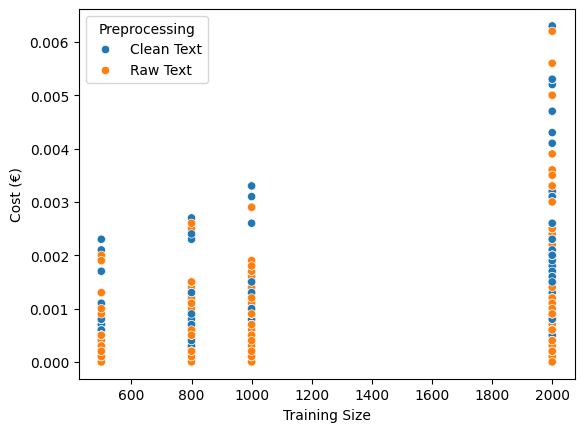

In [204]:
sns.scatterplot(y = tune_results['Cost (€)'], x = tune_results['Training Size'], hue = tune_results['Preprocessing'])

<Axes: xlabel='Training Size', ylabel='Best Score'>

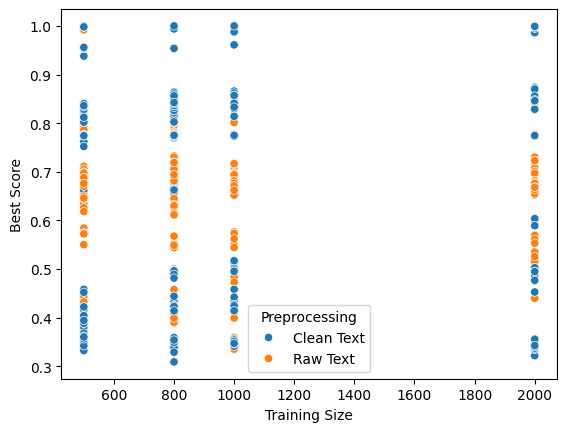

In [205]:
sns.scatterplot(y = tune_results['Best Score'], x = tune_results['Training Size'], hue = tune_results['Preprocessing'])

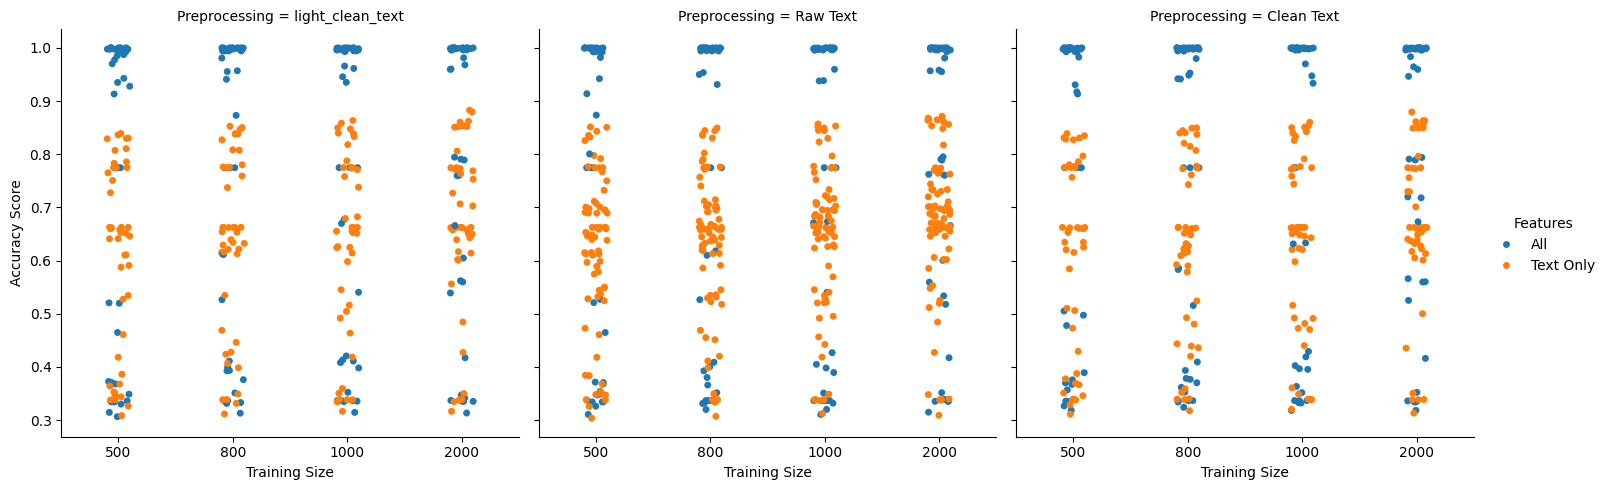

In [206]:
sns.catplot(y = clf_results['Accuracy Score'], col = clf_results['Preprocessing'], x = clf_results['Training Size'], hue = clf_results['Features'])

# Exporting Results

In [198]:
with open(f'{system}_tune_results_dict.json', "w") as outfile:
  json.dump(tune_results_dict, outfile)

In [199]:
with open(f'{system}_clf_results_dict.json', "w") as outfile:
  json.dump(clf_results_dict, outfile)

In [ ]:
# drive.mount('/content/drive')

In [200]:
shutil.copy(f'{system}_tune_results_dict.json', f'drive/MyDrive/Results/{system}_tune_results_dict_final.json')
shutil.copy(f'{system}_clf_results_dict.json', f'drive/MyDrive/Results/{system}_clf_results_dict_final.json')

'drive/MyDrive/Results/TPU_clf_results_dict_final.json'

# END

# TESTING

In [ ]:
# #############################
# class Memory_recorder:
#   def __init__(self, time_interval = 1):
#     self.time_interval = time_interval
#     self.running = False
#     self.recording_thread = None
#     a = subprocess.run('grep MemTotal: /proc/meminfo', shell = True, capture_output = True)
#     self.total_memory = int(a.stdout.decode('utf-8').split(':')[1][:-3])
#     del a
#     self.lowest_memory = None
#     self.free_memory = None
#     self.peak = None


#   def record_in_background(self):
#     while self.running:
#       shell_output = subprocess.run('grep MemAvailable: /proc/meminfo', shell = True, capture_output = True)
#       self.free_memory = int(shell_output.stdout.decode('utf-8').split(':')[1][:-3])
#       if self.free_memory < self.lowest_memory:
#         self.lowest_memory = self.free_memory
#       time.sleep(self.time_interval)

#   def start_recording(self):
#     self.lowest_memory = self.total_memory  # Reset lowest_memory for each iteration
#     self.running = True
#     self.recording_thread = multiprocessing.Process(target = self.record_in_background)
#     self.recording_thread.start()
#     print("Memory information recording started in the background.")

#   def stop_recording(self):
#     self.running = False
#     self.recording_thread.terminate()
#     print("Memory information recording stopped.")

#   def get_recording(self):
#     print("Memory information recording stopped.")
#     # self.running = False
#     # self.recording_thread.terminate()
#     self.peak = np.round((self.total_memory - self.lowest_memory)/(1024*1024), 2) # returns GBs
#     return self.peak



In [ ]:
recorder = Memory_recorder()
recorder.total_memory

In [ ]:
recorder.start_recording()

a = 0
for i in range(40000000):
  a += a *i

recorder.get_recording()

In [ ]:
recorder.free_memory

In [ ]:
a = subprocess.run('grep MemAvailable: /proc/meminfo', shell = True, capture_output = True)
free_memory = int(a.stdout.decode('utf-8').split(':')[1][:-3])
print(free_memory)